### Задачи

Доделать QE

Построить графики

Оформить про уровни депресси

Шкалы по TIPI

Шкала по VCL

Сравнение результатов

Зависимость скорости ответа от порядкового номера вопроса

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [196]:
file1=pd.read_csv('data.csv', sep='\t')

#### Описание данных

**1. Набор ответов на тест Q** (42 вопроса в рандомном порядке, где предлагается оценить, как часто он испытывал предложенные ощущения на протяжении последних 2-х недель)

***Q_i_A*** - ответ на i вопрос от 1 до 4, где 1 - никогда, 4 - очень часто или постоянно

***Q_i_E*** - количество милисекунд, потраченных на ответ

***Q_i_I*** - порядковый номер вопроса для данного участника

***introelapse*** The time spent on the introduction/landing page (in seconds) 

***testelapse***		The time spent on all the DASS questions (should be equivalent to the time elapsed on all the indiviudal questions combined)

***surveyelapse***	The time spent answering the rest of the demographic and survey questions

**2. Набор ответов на тест TIPI** (10 утверждений, предлагается оценить, насколько учатник согласен с каждым из них, по шкале от 1 - абсолютно не согласен, 7 - абсолютно согласен)

**3. Ответы на тест VCL** (предложено 16 слов, предлагается отметить, какие из них участник точно знает)

**4. Персональные данные**

***education***			 1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree

***urban (в детстве)***				 1=Rural (country side), 2=Suburban, 3=Urban (town, city)

***gender***				1=Male, 2=Female, 3=Other

***engnat***				1=Yes, 2=No

***age***					

***hand***				1=Right, 2=Left, 3=Both

***religion***			1=Agnostic, 2=Atheist, 3=Buddhist, 4=Christian (Catholic), 5=Christian (Mormon), 6=Christian (Protestant), 7=Christian (Other), 8=Hindu, 9=Jewish, 10=Muslim, 11=Sikh, 12=Other


***race***				10=Asian, 20=Arab, 30=Black, 40=Indigenous Australian, 50=Native American, 60=White, 70=Other

***voted***				1=Yes, 2=No

***married***				1=Never married, 2=Currently married, 3=Previously married

***familysize***	(количество детей у матери)		

***major***				

**5. Технические данные**

***country***				

***screensize***			1=device with small screen (phone, etc), 2=device with big screen (laptop, desktop, etc)

***uniquenetworklocation***		1=only one survey from user's specific network in dataset, 2=multiple surveys submitted from the network of this user  (2 does not necessarily imply duplicate records for an individual, as it could be different students at a single school or different memebers of the same household; and even if 1 there still could be duplicate records from a single individual e.g. if they took it once on their wifi and once on their phone)

***source***			1=from the front page of the site hosting the survey, 2=from google, 0=other or unknown

Проверим наличие пропущенных данных (датасет слишком большой чтобы использовать info())

In [37]:
file1.shape

(39775, 171)

In [4]:
pd.options.display.max_info_columns

100

In [5]:
for col in file1.columns:
    a=np.mean(file1[col].isnull())
    if a!=0:
        print(col, a)

country 5.02828409805154e-05
major 0.2866876178504085


In [8]:
file1[['major', 'country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39775 entries, 0 to 39774
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   major    28372 non-null  object
 1   country  39773 non-null  object
dtypes: object(2)
memory usage: 621.6+ KB


In [197]:
file1['major']=file1['major'].fillna('no')
file1['country']=file1['country'].fillna('no')

Проверим выбросы

In [4]:
bad_ans=[]
for col in ['Q'+str(i)+'A' for i in range(1,43)]:
    bad_ans+=(list(file1[~file1[col].isin([1,2,3,4])].index))
bad_ans #Ответы на тест Q заполнены правильно

[]

In [219]:
file1=pd.read_csv('data.csv', sep='\t')
file1['major']=file1['major'].fillna('no')
file1['country']=file1['country'].fillna('no')

In [198]:
#Переведём время ответов в секунды
file1[['Q'+str(i)+'E' for i in range(1,43)]]=file1[['Q'+str(i)+'E' for i in range(1,43)]]/1000

In [6]:
file1['testelapse'].describe() #нет отрицательных значений, есть явные выбросы

count    3.977500e+04
mean     2.684843e+03
std      1.482418e+05
min      1.200000e+01
25%      1.650000e+02
50%      2.130000e+02
75%      2.960000e+02
max      2.082972e+07
Name: testelapse, dtype: float64

In [7]:
file1[['Q'+str(i)+'E' for i in range(1,43)]].describe() #есть отрицательные значения - поменяем на противоположные
#есть явные выбросы

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q33E,Q34E,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E
count,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,...,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,6.970591,5.332376,7.426446,7.128728,5.919306,5.724097,9.776971,4.444627,18.330829,9.157494,...,5.272239,4.871684,14.105871,4.335748,6.811023,5.838114,8.472124,10.274100,5.540696,8.300695
std,86.705132,26.513611,158.702353,75.984858,64.282067,50.195831,442.758756,22.916182,1409.724444,418.635469,...,51.466986,108.623401,376.000379,30.703420,76.601331,301.126024,168.614116,320.856859,59.782867,77.650779
min,0.180000,0.176000,-10.814000,0.176000,0.178000,0.178000,0.178000,0.179000,0.177000,-19.695000,...,0.179000,-1.615000,0.183000,0.178000,-0.165000,-8.921000,-0.144000,0.178000,-0.159000,0.178000
25%,2.664000,2.477000,2.857000,2.949000,2.327000,2.369000,2.641500,2.104500,4.218000,2.427000,...,2.162000,1.922000,4.317500,1.681000,2.883000,1.897000,2.130500,3.393500,2.237000,3.070000
50%,3.609000,3.511000,3.898000,4.258000,3.237000,3.248000,3.702000,2.871000,6.139000,3.375000,...,2.993000,2.653000,6.499000,2.254000,4.054000,2.602000,2.930000,4.629000,3.052000,4.373000
75%,5.358000,5.216000,5.766000,6.285000,4.849000,4.788000,5.362000,4.239500,9.245000,5.027000,...,4.608000,4.003500,10.388000,3.484000,5.924000,3.934500,4.940000,6.733000,4.518000,6.681000
max,12102.282000,2161.057000,28582.689000,9488.330000,9467.497000,5426.858000,74124.488000,2103.626000,279772.213000,74471.124000,...,8658.903000,21328.973000,72970.668000,4133.123000,12710.289000,59401.008000,31773.217000,56297.555000,8021.110000,7750.098000


In [199]:
for col in ['Q'+str(i)+'E' for i in range(1,43)]:
    mask=(file1[col]<0)
    file1.loc[mask, col]*=-1

In [9]:
pd.Series(file1['testelapse']-file1[['Q'+str(i)+'E' for i in range(1,43)]].sum(axis=1)).describe()
#проверим разницу между реальной длительностью теста и записанной в столбце testelapse

count    3.977500e+04
mean     2.364809e+03
std      1.482231e+05
min     -2.295600e+01
25%      1.030500e+00
50%      2.237000e+00
75%      1.201700e+01
max      2.082853e+07
dtype: float64

In [166]:
#есть отрицательные значения (разница небольшая, проверить сами цифры, если всё ок, то просто пересчитать итоговое)
#выделить явные выбросы (где выбросы в критериях и где в итоге)
#если одновременные выбросы, поправить медианой время ответа и пересчитать итоговое
#если выбросы в ответах, то уменьшить их так, чтобы соответствовали итоговому
#если выброс в итоговом, то уменьшить его до реальной суммы

In [10]:
file1['time_diff']=file1['testelapse']-file1[['Q'+str(i)+'E' for i in range(1,43)]].sum(axis=1)

In [11]:
(file1['testelapse']-file1[qe_names[:-1]].median(axis=1)*42).describe()

NameError: name 'qe_names' is not defined

In [225]:
mask=(file1['testelapse']-file1[qe_names[:-1]].median(axis=1)*42<0)
file1.loc[mask, ['testelapse', 'time_diff']]

,testelapse,time_diff
499,330,0.141
873,280,0.556
971,152,0.496
1507,211,0.104
1910,118,0.155
2069,417,0.790
2236,159,0.193
2260,688,2.377
2625,218,1.908
3590,169,-0.049


In [226]:
file1.loc[mask, 'testelapse']=file1.loc[mask, qe_names[:-1]].sum(axis=1)
file1.loc[mask, 'time_diff']=0

In [227]:
mask=(file1['testelapse']-file1[qe_names[:-1]].median(axis=1)*42>0)&(file1['time_diff']<0)
file1.loc[mask, ['testelapse', 'time_diff']].describe()
#итоговое меньше, чем реальная сумма, но по медиане разница должна быть обратная, то есть в ответах могут быть выбросы

,testelapse,time_diff
count,1094.000000,1094.000000
mean,291.919561,-0.406048
std,1660.048872,1.417219
min,12.000000,-22.956000
25%,134.000000,-0.347500
50%,171.000000,-0.178500
75%,227.000000,-0.081250
max,39421.000000,-0.001000


In [228]:
mask2=(file1['testelapse']-file1[qe_names[:-1]].median(axis=1)*42>0)&(file1['time_diff']<0)\
&(file1['time_diff']>=-0.3475)
file1.loc[mask2, 'time_diff']=0
file1.loc[mask2, 'testelapse']=file1.loc[mask2, qe_names[:-1]].sum(axis=1)

In [230]:
mask3=(file1['testelapse']-file1[qe_names[:-1]].median(axis=1)*42>0)&(file1['time_diff']<-0.3475)
file1.loc[mask3, ['testelapse','time_diff']].describe()

,testelapse,time_diff
count,274.000000,274.000000
mean,368.587591,-1.201423
std,2387.904745,2.677247
min,12.000000,-22.956000
25%,133.250000,-0.632250
50%,176.500000,-0.502000
75%,229.000000,-0.416250
max,39421.000000,-0.348000


In [213]:
mask=(file1['testelapse']-file1[qe_names[:-1]].median(axis=1)*42<0)&(file1['time_diff']<0)
file1.loc[mask, ['testelapse', 'time_diff']].describe()

,testelapse,time_diff
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [214]:
mask=(file1['testelapse']-file1[qe_names[:-1]].median(axis=1)*42>0)&(file1['time_diff']>0)
file1.loc[mask, ['testelapse', 'time_diff']].describe()
#итоговое больше, чем реальная сумма, что соответствует медиане

,testelapse,time_diff
count,3.865200e+04,3.865200e+04
mean,2.754386e+03,2.433526e+03
std,1.503791e+05,1.503605e+05
min,1.300000e+01,2.842171e-14
25%,1.660000e+02,1.101000e+00
50%,2.150000e+02,2.418000e+00
75%,2.980000e+02,1.252325e+01
max,2.082972e+07,2.082853e+07


In [170]:
qe_names=['Q'+str(i)+'E' for i in range(1,43)]+['testelapse']
mask=(file1['time_diff']<0)
file1.loc[mask, qe_names[:-1]].describe()

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q33E,Q34E,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,...,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,6.172005,3.980339,4.769579,5.696216,4.165000,6.279734,38.518156,3.904190,8.387023,4.593430,...,3.682062,3.615909,10.651062,3.191358,5.049151,3.955766,3.893435,5.446676,3.790908,7.086144
std,34.719311,6.315513,6.333715,17.919276,6.629999,50.264137,1124.174129,17.716611,28.855970,13.302456,...,4.287145,11.585846,79.434323,5.643545,7.533574,16.336082,5.923809,7.185404,5.072471,46.873116
min,0.192000,0.193000,0.187000,0.188000,0.186000,0.191000,0.185000,0.190000,0.215000,0.187000,...,0.218000,0.216000,0.240000,0.204000,0.226000,0.188000,0.185000,0.188000,0.189000,0.188000
25%,2.402000,2.092500,2.505000,2.692750,2.174500,2.186750,2.307750,1.936750,3.546250,2.195750,...,2.002750,1.727750,3.658250,1.605500,2.487250,1.762750,1.939750,2.982000,2.029000,2.660250
50%,3.267000,2.920500,3.475500,3.862500,2.923000,2.953500,3.210500,2.546000,5.100500,2.971500,...,2.682000,2.382000,5.403000,2.130000,3.510500,2.317500,2.534500,4.075000,2.673000,3.709500
75%,4.749250,4.168250,5.026000,5.785000,4.217250,4.304250,4.796750,3.653500,7.410500,4.437500,...,3.941750,3.409250,8.369750,3.223250,5.031750,3.446250,3.651500,5.658000,3.915000,5.363000
max,1101.981000,159.912000,113.523000,550.797000,126.897000,1561.265000,37220.816000,573.081000,573.679000,393.702000,...,76.417000,367.022000,2562.937000,140.499000,123.230000,499.906000,101.460000,136.789000,124.768000,1517.125000


In [ ]:
pd.Series(file1['testelapse']-file1[['Q'+str(i)+'E' for i in range(1,43)]].sum(axis=1)).sort_values(ascending=False)[:-2000]

In [144]:
for col in ['Q'+str(i)+'E' for i in range(1,43)]:
    mask=(file1[col]>testelapse_med)
    file1.loc[mask, col]=file1.loc[mask,['Q'+str(i)+'E' for i in range(1,43)]].median()

In [148]:
p=file1[['Q'+str(i)+'E' for i in range(1,43)]].sum(axis=1).describe()['75%']

In [157]:
mask=(file1[['Q'+str(i)+'E' for i in range(1,43)]].sum(axis=1)>p)
(file1.loc[mask, 'testelapse']-file1.loc[mask, ['Q'+str(i)+'E' for i in range(1,43)]].sum(axis=1)).describe()

count    9.944000e+03
mean     7.659767e+03
std      2.836790e+05
min     -2.273737e-13
25%      1.511000e+00
50%      4.877000e+00
75%      2.875325e+01
max      2.082908e+07
dtype: float64

насколько большими могут быть выбросы???

In [200]:
q_i=['Q'+str(i)+'I' for i in range(1,43)]

In [201]:
sum([file1[file1[col]<1][col].count() for col in q_i]), sum([file1[file1[col]>42][col].count() for col in q_i])


(0, 0)

В признаках Q_i_I нет ошибок

___

In [202]:
bad_ans=[]
for col in ['TIPI'+str(i) for i in range(1,11)]:
    bad_ans+=(list(file1[~file1[col].isin([1,2,3,4,5,6,7])].index))
len(bad_ans)

5357

In [203]:
file1.loc[bad_ans,['TIPI'+str(i) for i in range(1,11)]].value_counts(normalize=True)

TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  TIPI8  TIPI9  TIPI10
0      0      0      0      0      0      0      0      0      0         0.442412
3      0      0      0      0      0      0      0      0      0         0.018480
1      0      0      0      0      0      0      0      0      0         0.016800
0      0      0      6      0      0      0      0      0      0         0.015120
                     7      0      0      0      0      0      0         0.015120
                                                                           ...   
3      4      6      0      6      6      7      5      3      2         0.000187
                     6      4      5      5      0      1      4         0.000187
                     7      1      1      0      7      3      7         0.000187
       5      0      6      2      3      4      5      3      7         0.000187
7      7      7      7      7      7      7      7      7      0         0.000187
Length: 1124, dtype: float64

In [204]:
ind_to_delete=[]
for j in list(set(bad_ans)):
    if file1[['TIPI'+str(i) for i in range(1,11)]].iloc[j].value_counts(normalize=True)[0]>=0.4:
        ind_to_delete.append(j)
file1=file1.drop(ind_to_delete)
#удалили записи, где большая часть информации потеряна

In [205]:
for x in ind_to_delete: bad_ans.remove(x)

In [206]:
for col in ['TIPI'+str(i) for i in range(1,11)]:
    mask=(file1[col]==0)
    file1.loc[mask, col]=file1.loc[mask, ['TIPI'+str(i) for i in range(1,11)]].median(axis=1)
file1.loc[:,['TIPI'+str(i) for i in range(1,11)]]=file1.loc[:,['TIPI'+str(i) for i in range(1,11)]].astype('int')

In [207]:
file1[['TIPI'+str(i) for i in range(1,11)]].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000
mean,3.834080,4.252495,4.811290,5.228967,4.998014,4.909070,5.349027,4.352236,3.689804,3.785038
std,1.865816,1.763183,1.718157,1.746254,1.637332,1.836151,1.500705,1.901395,1.799584,1.821930
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,3.000000,4.000000,5.000000,4.000000,4.000000,5.000000,3.000000,2.000000,2.000000
50%,4.000000,5.000000,5.000000,6.000000,5.000000,5.000000,6.000000,5.000000,4.000000,4.000000
75%,5.000000,6.000000,6.000000,7.000000,6.000000,6.000000,7.000000,6.000000,5.000000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


___

In [209]:
mask=(~file1['education'].isin([1,2,3,4]))
file1.loc[mask, 'education'].describe()

count    504.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: education, dtype: float64

In [210]:
file1['education']=file1['education'].replace(0,1)
file1['education'].describe()

count    39272.000000
mean         2.516144
std          0.856067
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: education, dtype: float64

In [211]:
bad_ans=[]
bad_ans+=(list(file1[file1['age']>150].index))+(list(file1[file1['age']<=0].index))
len(bad_ans)

4

In [212]:
mask=((file1['age']>150)|(file1['age']<=0))
file1.loc[mask,'age']

5340      223
10231    1996
30027    1993
33730    1991
Name: age, dtype: int64

In [213]:
file1.loc[5340, 'age']=23#видимо ошибка ввода, должно быть 22 или 23
mask=((file1['age']>150)&(file1['age']!=223))
#3 человека видимо написали свои года рождения

In [214]:
file1.loc[mask,'age']=2023-file1.loc[mask,'age']

In [215]:
file1['age'].describe()

count    39272.000000
mean        23.420350
std          8.617472
min         13.000000
25%         18.000000
50%         21.000000
75%         25.000000
max        117.000000
Name: age, dtype: float64

In [282]:
file1.religion.value_counts(normalize=True)

10    0.552098
2     0.097576
1     0.082374
4     0.078326
7     0.056962
12    0.045452
6     0.039137
8     0.017544
3     0.013394
0     0.008810
9     0.003616
5     0.003081
11    0.001630
Name: religion, dtype: float64

In [216]:
mask=(file1['religion']==0)
file1.loc[mask,'religion']=12     

In [39]:
[file1[col].value_counts(normalize=True) for col in ['urban', 'gender','hand', 'married']]

[3    0.447647
 2    0.334513
 1    0.208826
 0    0.009014
 Name: urban, dtype: float64,
 2    0.762630
 1    0.221863
 3    0.013878
 0    0.001630
 Name: gender, dtype: float64,
 1    0.873778
 2    0.104451
 3    0.017442
 0    0.004329
 Name: hand, dtype: float64,
 1    0.858907
 2    0.109391
 3    0.027348
 0    0.004354
 Name: married, dtype: float64]

In [217]:
for col in ['urban', 'gender','hand', 'married']:
    file1[col]=file1[col].replace(0, int(file1[col].median()))

In [42]:
[file1[col].value_counts(normalize=True) for col in ['engnat', 'voted','screensize','uniquenetworklocation']]

[2    0.636229
 1    0.362752
 0    0.001019
 Name: engnat, dtype: float64,
 2    0.713816
 1    0.278672
 0    0.007512
 Name: voted, dtype: float64,
 1    0.723569
 2    0.276431
 Name: screensize, dtype: float64,
 1    0.800672
 2    0.199328
 Name: uniquenetworklocation, dtype: float64]

Для локации и размера экрана всё ок

In [218]:
for col in ['engnat', 'voted']:
    file1[col]=file1[col].replace(0, int(file1[col].median()))

In [46]:
file1[file1['familysize']>4]['familysize'].value_counts()

5      4754
6      2404
7      1218
8       664
9       325
10      192
11      108
12       54
13       18
14        8
15        6
16        5
17        3
26        1
19        1
99        1
65        1
21        1
133       1
54        1
62        1
24        1
23        1
Name: familysize, dtype: int64

In [219]:
file1['familysize']=file1['familysize'].replace(list(file1[file1['familysize']>54]['familysize']),\
                                                int(file1['familysize'].median()))

In [48]:
file1.race.value_counts()

10    22733
60    10612
70     4763
30      597
20      325
50      220
40       22
Name: race, dtype: int64

In [49]:
file1.source.value_counts()

0    14312
1    13977
2    10983
Name: source, dtype: int64

Очистили и исправили данные

!!!!!
$Почистить QiE$

In [349]:
i=1
file1[['Q'+str(_)+'E' for _ in range(1,43)]+['Q'+str(_)+'I' for _ in range(1,43)]].sort_values(by=['Q'+str(_)+'I' for _ in range(1,43)])

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q33I,Q34I,Q35I,Q36I,Q37I,Q38I,Q39I,Q40I,Q41I,Q42I
14890,22.228,7.331,4.507,2.962,3.060,9.897,4.778,9.275,5.353,2.714,...,13,17,19,39,4,22,14,24,41,23
14394,5.227,6.216,23.666,5.735,9.496,5.016,5.351,2.665,14.769,3.501,...,41,7,35,26,14,15,20,17,33,24
30317,1.280,0.297,0.341,0.344,0.357,0.321,0.388,0.334,0.382,0.199,...,6,31,36,21,12,4,26,16,42,22
34438,45.511,844.028,10.980,3.626,3.562,6.246,7.446,4.619,5.718,19.750,...,8,3,14,33,37,29,35,12,30,41
1187,6.559,10.445,13.794,6.630,2.198,6.599,7.177,11.354,7.602,4.523,...,17,8,27,7,13,32,33,6,4,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7237,5.808,3.141,4.368,3.465,14.827,3.465,3.418,3.479,8.026,3.192,...,6,12,13,26,30,17,9,22,36,31
25626,3.408,4.858,3.243,2.583,1.574,1.720,6.439,3.887,6.484,2.118,...,10,24,4,37,35,16,11,33,17,22
26989,4.136,2.337,2.771,2.041,4.724,4.376,6.133,4.393,6.225,3.144,...,4,26,16,22,20,13,35,10,32,6
13869,2.466,2.233,2.100,3.501,2.283,2.884,2.084,3.083,2.883,1.666,...,35,21,20,16,17,4,25,34,38,19


Можно посмотреть, как меняется время ответа на протяжении теста

можно посмотреть, сколько в среднем тратят на каждый вопрос

Как меняется время ответа на вопрос в зависимости от его номера в тесте

In [80]:
df1=pd.DataFrame({'QE': list(file1.loc[1, ['Q'+str(_)+'E' for _ in range(1,43)]]), 'QI':\
                 list(file1.loc[1, ['Q'+str(_)+'I' for _ in range(1,43)]])}, index=range(1,43))

<AxesSubplot:xlabel='QI', ylabel='QE'>

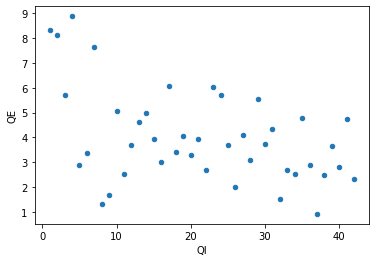

In [84]:
df2=df1.sort_values(by='QI').copy()
df2.plot(kind='scatter', x='QI',y='QE')

<AxesSubplot:>

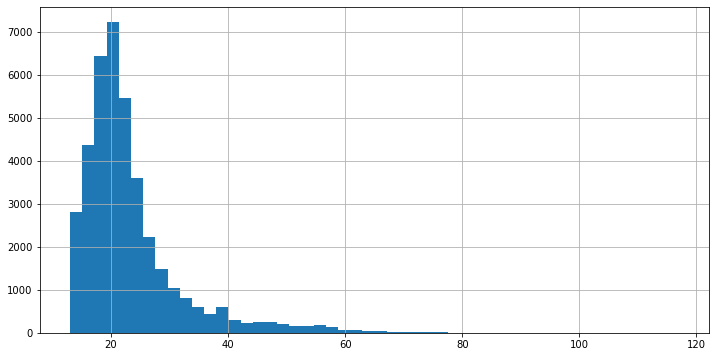

In [313]:
fig=plt.figure(figsize=(12,6))
file1['age'].hist(bins=50)

В тестировании в основном участвовала молодёжь 

Можно сопоставить уровень депрессивности и возраст

In [85]:
columns_names=file1.columns
scale_q_names=list(columns_names[:126])+['introelapse', 'testelapse', 'surveyelapse','time_diff']
scale_q_data=file1[scale_q_names]

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q41A,Q41I,Q41E,Q42A,Q42I,Q42E,introelapse,testelapse,surveyelapse,time_diff
count,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,...,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,3.927200e+04,3.927200e+04,3.927200e+04,3.927200e+04
mean,2.619042,21.553855,6.976773,2.171853,21.263521,5.322752,2.225428,21.597067,7.438817,1.949277,...,1.965726,21.482914,5.525426,2.682496,21.457603,8.300620,2.420454e+03,2.692577e+03,4.724828e+03,2.372435e+03
std,1.031888,12.128391,87.253659,1.111529,12.125698,26.668834,1.038380,12.115192,159.713363,1.041804,...,1.045840,12.117149,60.148753,1.032240,12.142644,78.128094,1.389723e+05,1.491238e+05,1.853921e+05,1.491052e+05
min,1.000000,1.000000,0.180000,1.000000,1.000000,0.176000,1.000000,1.000000,0.178000,1.000000,...,1.000000,1.000000,0.159000,1.000000,1.000000,0.178000,0.000000e+00,1.200000e+01,1.000000e+00,-2.295600e+01
25%,2.000000,11.000000,2.661000,1.000000,11.000000,2.472000,1.000000,11.000000,2.854000,1.000000,...,1.000000,11.000000,2.235000,2.000000,11.000000,3.068000,3.000000e+00,1.640000e+02,1.460000e+02,1.027000e+00
50%,3.000000,22.000000,3.605000,2.000000,21.000000,3.503000,2.000000,22.000000,3.891000,2.000000,...,2.000000,21.000000,3.048000,3.000000,21.000000,4.369000,7.000000e+00,2.130000e+02,1.860000e+02,2.227500e+00
75%,4.000000,32.000000,5.353250,3.000000,32.000000,5.202000,3.000000,32.000000,5.753000,3.000000,...,3.000000,32.000000,4.507000,4.000000,32.000000,6.669000,2.000000e+01,2.950000e+02,2.480000e+02,1.199025e+01
max,4.000000,42.000000,12102.282000,4.000000,42.000000,2161.057000,4.000000,42.000000,28582.689000,4.000000,...,4.000000,42.000000,8021.110000,4.000000,42.000000,7750.098000,2.082974e+07,2.082972e+07,2.082845e+07,2.082853e+07


In [86]:
tech_names=['country', 'source','screensize', 'uniquenetworklocation']
data_tech=file1[tech_names]

scale_t_names=['TIPI'+str(i) for i in range(1,11)]
scale_t_data=file1[scale_t_names]

scale_v_names=['VCL'+str(i) for i in range(1,17)]
scale_v_data=file1[scale_t_names]

personal_info_names=list(columns_names[157:162])+list(columns_names[164:171])
personal_info=file1[personal_info_names]

In [87]:
scales_q_answers=scale_q_data[['Q'+str(i)+'A' for i in range(1,43)]]
res=scales_q_answers.sum(axis=1)
res.name='result'
scales_q_answers=pd.concat([scales_q_answers, res], axis=1)
scales_q_answers.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q34A,Q35A,Q36A,Q37A,Q38A,Q39A,Q40A,Q41A,Q42A,result
0,4,4,2,4,4,4,4,4,2,1,...,3,4,4,1,2,4,3,4,4,143
1,4,1,2,3,4,4,3,4,3,2,...,2,2,3,4,2,2,1,2,2,110
2,3,1,4,1,4,3,1,3,2,4,...,4,3,4,4,4,2,2,1,4,110
3,2,3,2,1,3,3,4,2,3,3,...,4,1,1,2,1,3,4,4,2,91
4,2,2,3,4,4,2,4,4,4,3,...,4,3,4,3,3,3,4,4,3,143


In [88]:
def levels(x, arr):
    for el in arr:
        if x<=el:
            return arr.index(el)
    return 'error'

In [89]:
res2=scales_q_answers['result'].apply(levels, arr=list(res.describe()[4:]))
res2.name='depr_level_q'
scales_q_answers=pd.concat([scales_q_answers,res2], axis=1)
scales_q_answers.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q35A,Q36A,Q37A,Q38A,Q39A,Q40A,Q41A,Q42A,result,depr_level_q
0,4,4,2,4,4,4,4,4,2,1,...,4,4,1,2,4,3,4,4,143,3
1,4,1,2,3,4,4,3,4,3,2,...,2,3,4,2,2,1,2,2,110,2
2,3,1,4,1,4,3,1,3,2,4,...,3,4,4,4,2,2,1,4,110,2
3,2,3,2,1,3,3,4,2,3,3,...,1,1,2,1,3,4,4,2,91,1
4,2,2,3,4,4,2,4,4,4,3,...,3,4,3,3,3,4,4,3,143,3


In [115]:
names4=[]
for name in ['Q'+str(i)+'A' for i in range(1,43)]:
    if scales_q_answers[name].value_counts(normalize=True,sort=False).idxmax()==4:
        names4.append(name)
names4
 

['Q11A', 'Q13A', 'Q17A', 'Q34A', 'Q40A']

На эти вопросы чаще всего выбирали вариант ответа 4 (соответствует более тяжёлому проявлению депирессивного симптома)

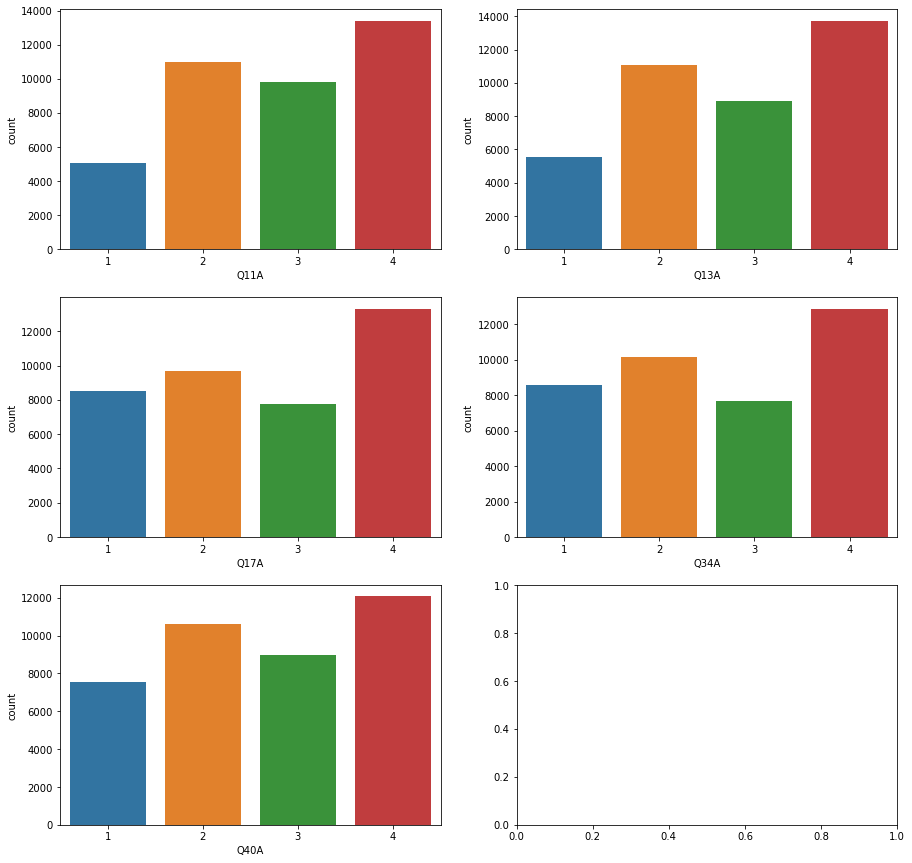

In [132]:
fig, ax=plt.subplots(3,2, figsize=(15,15))
i,j=0,0
for name in names4:
    sns.countplot(x=scales_q_answers[name], ax=ax[i,j])
    j+=1
    if j==2:
        j=0
        i+=1

В вопросах 11 и 13 видна существенная разница между количеством ответов 1 и 4, в остальных случаях разница не так велика. Возможно эти симптомы более распространены и у здоровых людей.

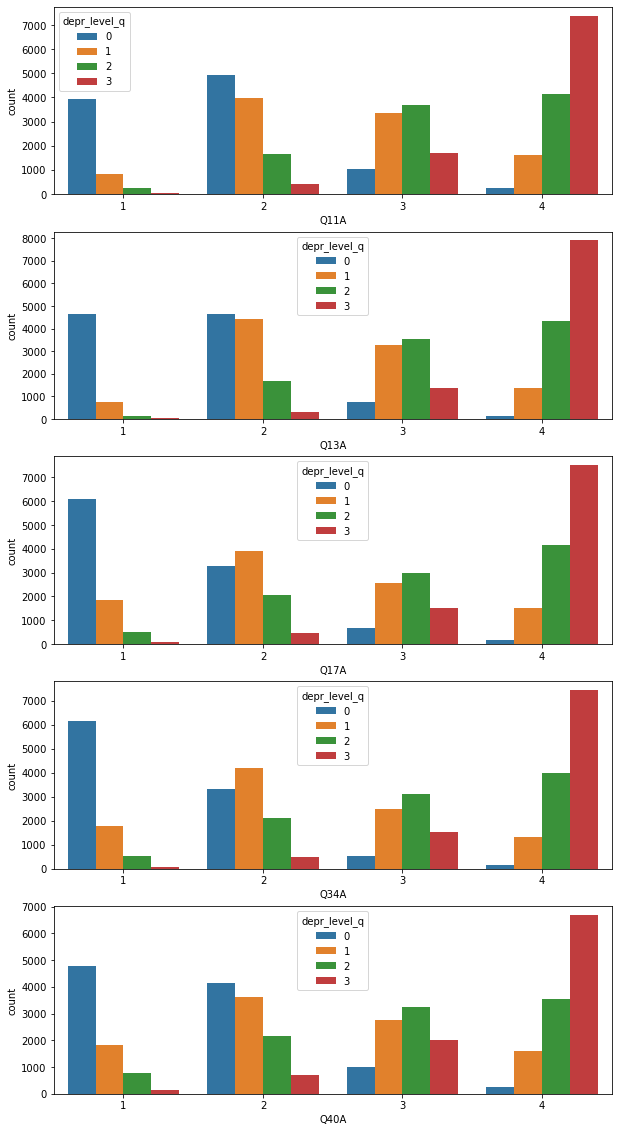

In [122]:
fig, ax=plt.subplots(5, figsize=(10,20))
i=0
for name in names4:
    sns.countplot(x=scales_q_answers[name], hue=scales_q_answers['depr_level_q'], ax=ax[i])
    i+=1

Видно, что вариант 4 обычно выбирают люди с целом более выраженными депрессивными симптомами

In [133]:
names1=[]
for name in ['Q'+str(i)+'A' for i in range(1,43)]:
    if scales_q_answers[name].value_counts(normalize=True,sort=False).idxmax()==1:
        names1.append(name)
names1 

['Q2A',
 'Q4A',
 'Q7A',
 'Q15A',
 'Q19A',
 'Q20A',
 'Q21A',
 'Q23A',
 'Q25A',
 'Q28A',
 'Q36A',
 'Q37A',
 'Q38A',
 'Q41A']

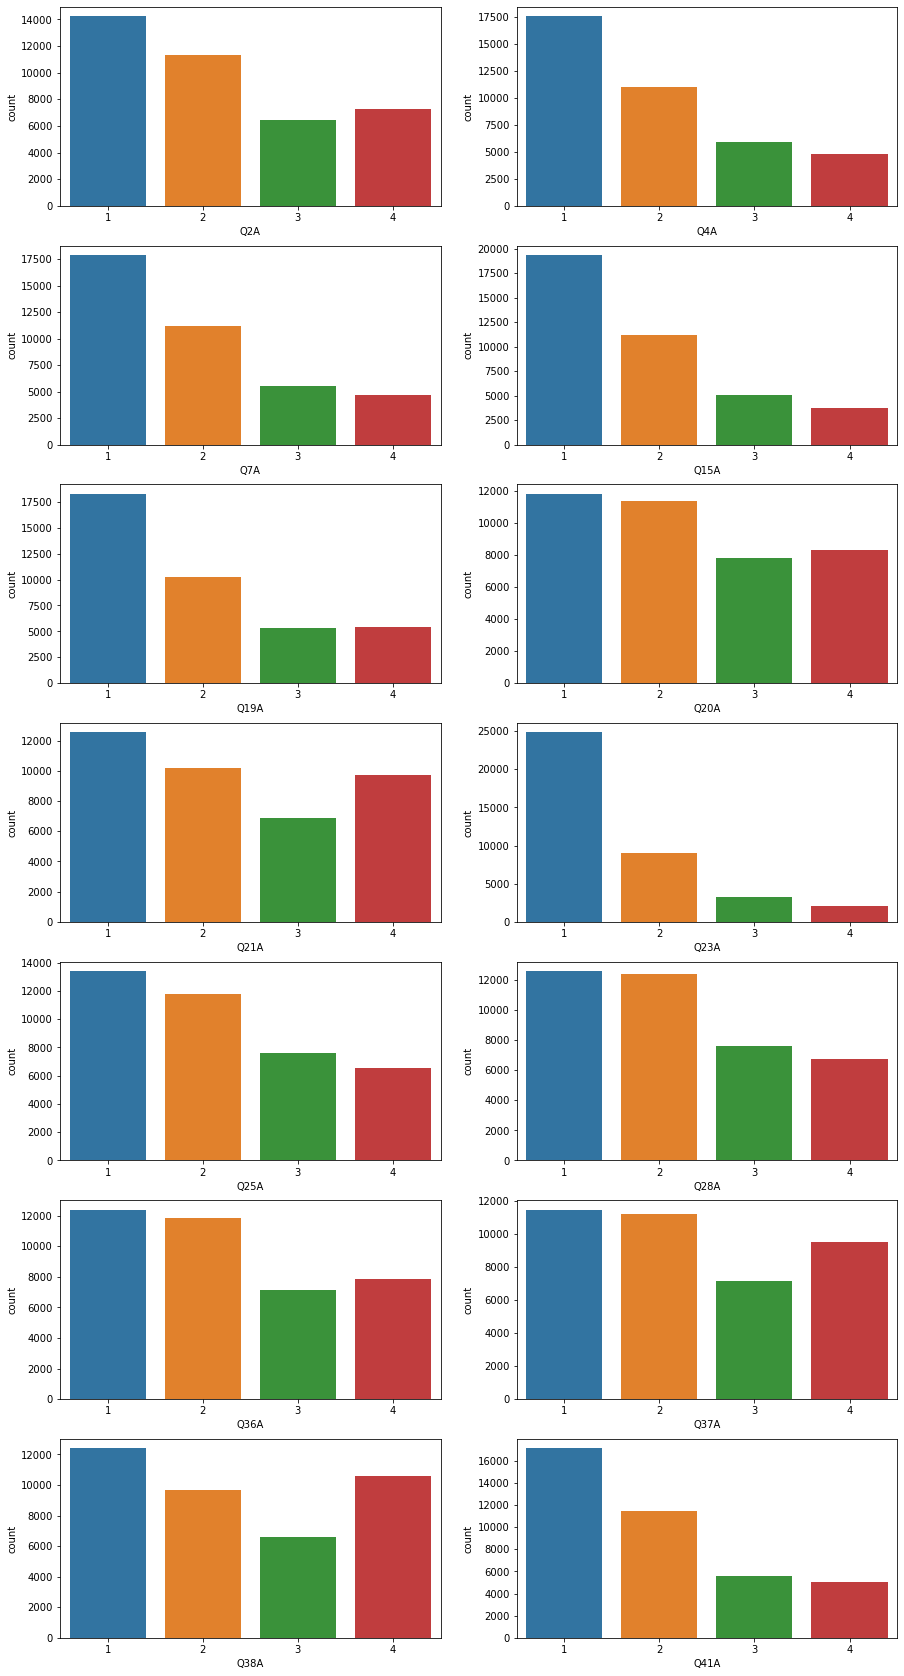

In [138]:
fig, ax=plt.subplots(7,2, figsize=(15,30))
i,j=0,0
for name in names1:
    sns.countplot(x=scales_q_answers[name], ax=ax[i,j])
    j+=1
    if j==2:
        j=0
        i+=1

На вопросы 15 и 23 реже всего отвечают "4", проверим, как ответы на эти вопросы соотносятся с проявлением депрессивных симптомов в целом

<AxesSubplot:xlabel='Q23A', ylabel='count'>

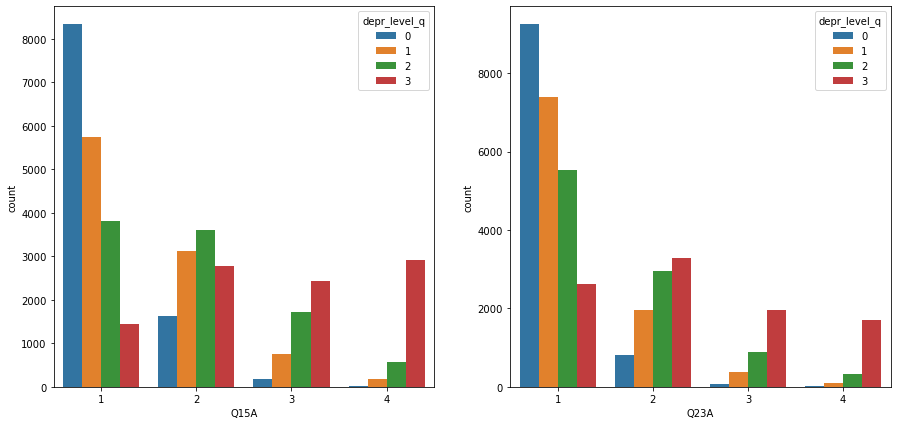

In [145]:
fig, ax=plt.subplots(1,2, figsize=(15,7))
sns.countplot(x=scales_q_answers['Q15A'], hue=scales_q_answers['depr_level_q'], ax=ax[0])
sns.countplot(x=scales_q_answers['Q23A'], hue=scales_q_answers['depr_level_q'], ax=ax[1])

Для людей с выраженными депрессивными симптомами вопросы 15 и 23 не являются определяющими

Q15	I had a feeling of faintness

Q23	I had difficulty in swallowing

Доли ответов на вопросы 20, 21, 36, 37, 38 имеют небольшой разброс. Рассмотрим их в зависимости от степени выраженности депрессивных симптомов

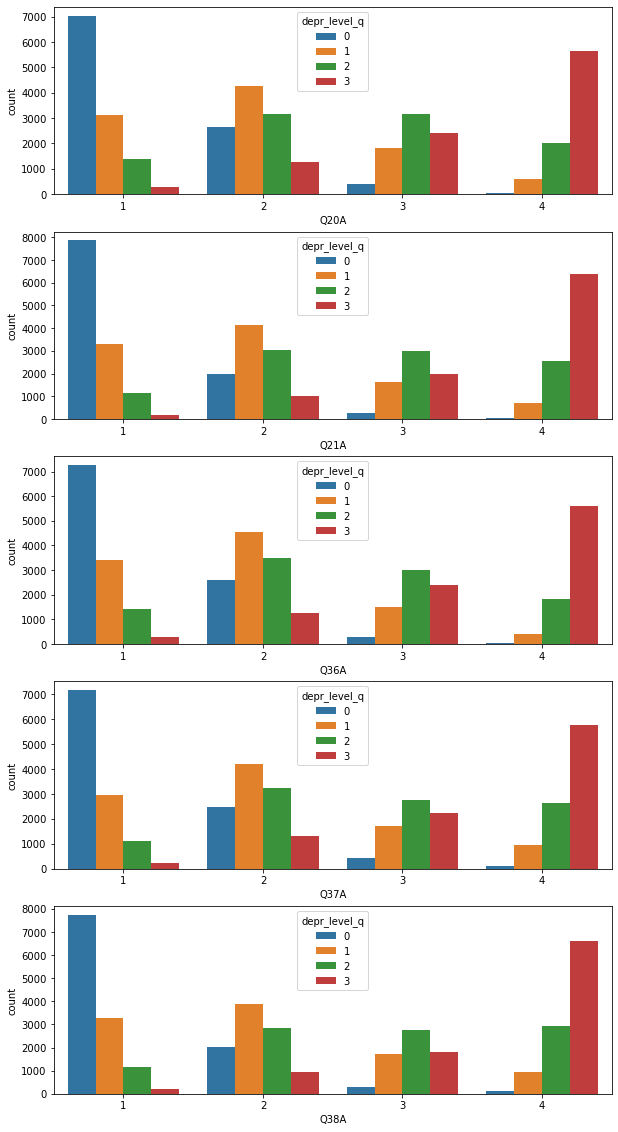

In [146]:
fig, ax=plt.subplots(5, figsize=(10,20))
i=0
for name in ['Q20A', 'Q21A', 'Q36A','Q37A','Q38A']:
    sns.countplot(x=scales_q_answers[name], hue=scales_q_answers['depr_level_q'], ax=ax[i])
    i+=1

Люди со средним проявлением депрессии (уровень 2) симптомы 21, 37, 38 встречаются примерно одинаково в разной степени интенсивности. Для людей с другими уровнями депрессивности прослеживается более чёткая связь между вариантом ответа и тяжестью депресси в целом.

Q21	I felt that life wasn't worthwhile

Q37	I could see nothing in the future to be hopeful about.

Q38	I felt that life was meaningless.

<AxesSubplot:>

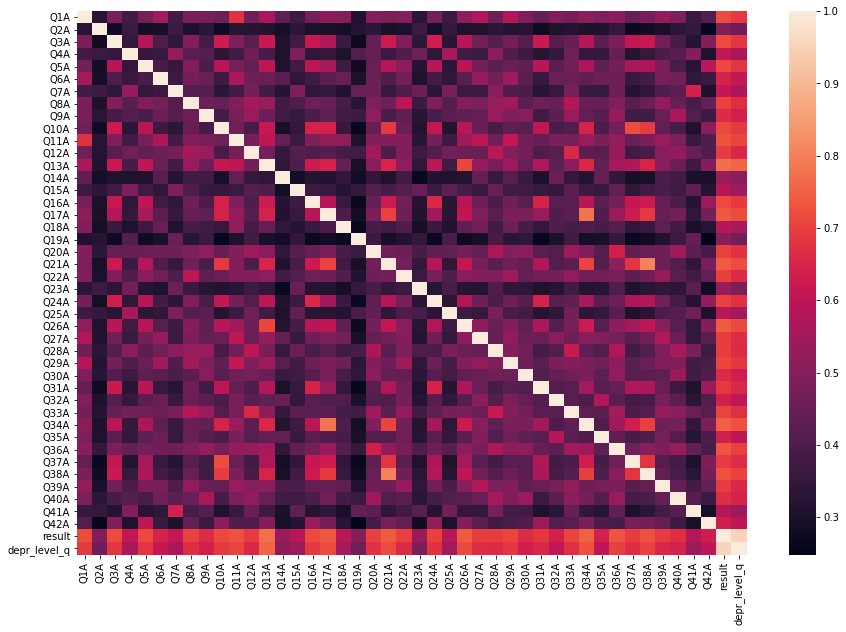

In [45]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(scales_q_answers.corr())

In [148]:
a=scales_q_answers.corr().unstack()['result']

In [149]:
b=a[:-2].sort_values()
important_q=b[-10:].index#чем больше корр тем больше результат зависит от вопроса
list(important_q)

['Q10A', 'Q3A', 'Q11A', 'Q36A', 'Q38A', 'Q17A', 'Q26A', 'Q21A', 'Q34A', 'Q13A']

In [ ]:
#corr->1 - лин зав
#corr->0 - лин незав

<AxesSubplot:>

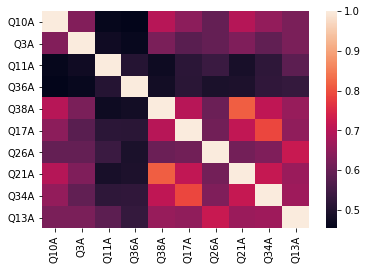

In [150]:
sns.heatmap(scales_q_answers[important_q].corr())

Есть существенная корреляция между вопросами 38-21 и 17-34

Q17	I felt I wasn't worth much as a person.  Q34	I felt I was pretty worthless

Q21	I felt that life wasn&#39;t worthwhile  Q38	I felt that life was meaningless

В целом, такой результат ожидаем, формулировки похожи

In [167]:
scales_q_answers[scales_q_answers['Q17A']==scales_q_answers['Q34A']][['Q17A', 'depr_level_q']].\
                                                                     value_counts(sort=False,normalize=True)

Q17A  depr_level_q
1     0               0.192569
      1               0.040785
      2               0.008938
      3               0.001093
2     0               0.074194
      1               0.094294
      2               0.039341
      3               0.007142
3     0               0.007650
      1               0.045742
      2               0.059558
      3               0.025837
4     0               0.001834
      1               0.029584
      2               0.114121
      3               0.257318
dtype: float64

In [171]:
scales_q_answers[scales_q_answers['Q17A']!=scales_q_answers['Q34A']][['Q17A', 'depr_level_q']].\
                                                                     value_counts(sort=False,normalize=True)

Q17A  depr_level_q
1     0               0.084762
      1               0.059341
      2               0.021099
      3               0.003223
2     0               0.099267
      1               0.109158
      2               0.076557
      3               0.020293
3     0               0.033919
      1               0.102418
      2               0.107033
      3               0.063370
4     0               0.008352
      1               0.053993
      2               0.090769
      3               0.066447
dtype: float64

In [151]:
#уберём вопросы, между которыми есть существенная корреляция
important_q=list(important_q)
important_q.remove('Q38A')
important_q.remove('Q34A')
important_q

['Q10A', 'Q3A', 'Q11A', 'Q36A', 'Q17A', 'Q26A', 'Q21A', 'Q13A']

In [153]:
scales_q_answers1=scales_q_answers[important_q+['depr_level_q']]
scales_q_answers1.head()

,Q10A,Q3A,Q11A,Q36A,Q17A,Q26A,Q21A,Q13A,depr_level_q
0,1,2,4,4,3,4,1,4,3
1,2,2,2,3,4,3,2,4,2
2,4,4,2,4,4,1,4,4,2
3,3,2,2,1,3,2,1,1,1
4,3,3,2,4,4,4,3,4,3


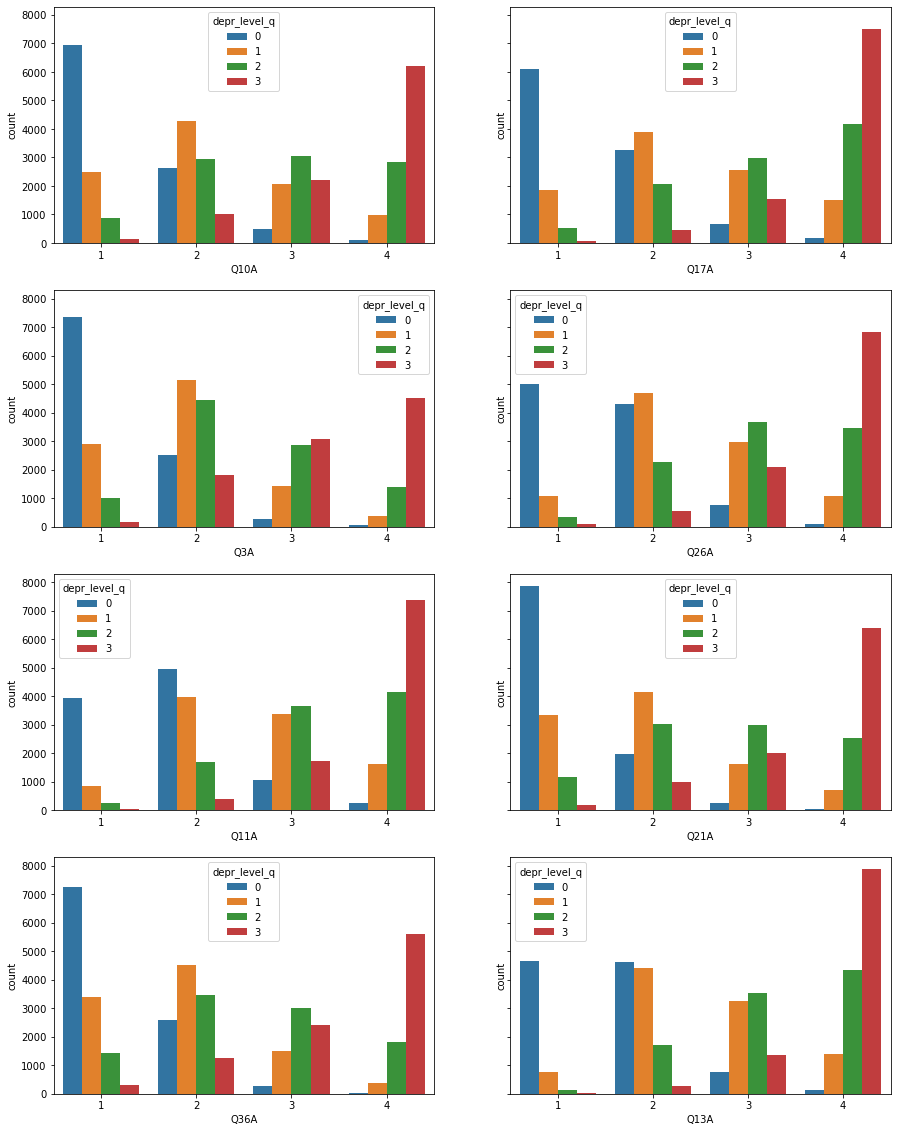

In [155]:
fig, ax=plt.subplots(4,2, figsize=(15,20),sharey=True)
i,j=0,0
for name in scales_q_answers1.columns[:-1]:
    sns.countplot(x=scales_q_answers1[name], hue=scales_q_answers1['depr_level_q'], ax=ax[i,j])
    i+=1
    if i==4:
        j+=1
        i=0

Q16	I felt that I had lost interest in just about everything.
Q17	I felt I wasn&#39;t worth much as a person.

Q1	I found myself getting upset by quite trivial things.
Q26	I felt down-hearted and blue.

Q11	I found myself getting upset rather easily.
Q21	I felt that life wasn&#39;t worthwhile.

Q36	I felt terrified.
Q13	I felt sad and depressed.

<AxesSubplot:>

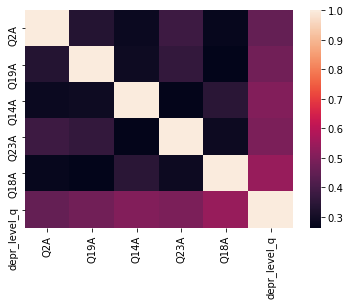

In [172]:
#less important
#b=a[:-2].sort_values()
not_important_q=b[:5].index
not_important_q=list(not_important_q)
scale_q_bad=scales_q_answers[not_important_q+['depr_level_q']]
sns.heatmap(scale_q_bad.corr())

In [173]:
#q14 (getting impatient) можно заменить остальными
#q2~q18~q19
not_important_q.remove('Q14A')
not_important_q.remove('Q18A')

In [174]:
scale_q_bad=scale_q_bad[not_important_q+['depr_level_q']]

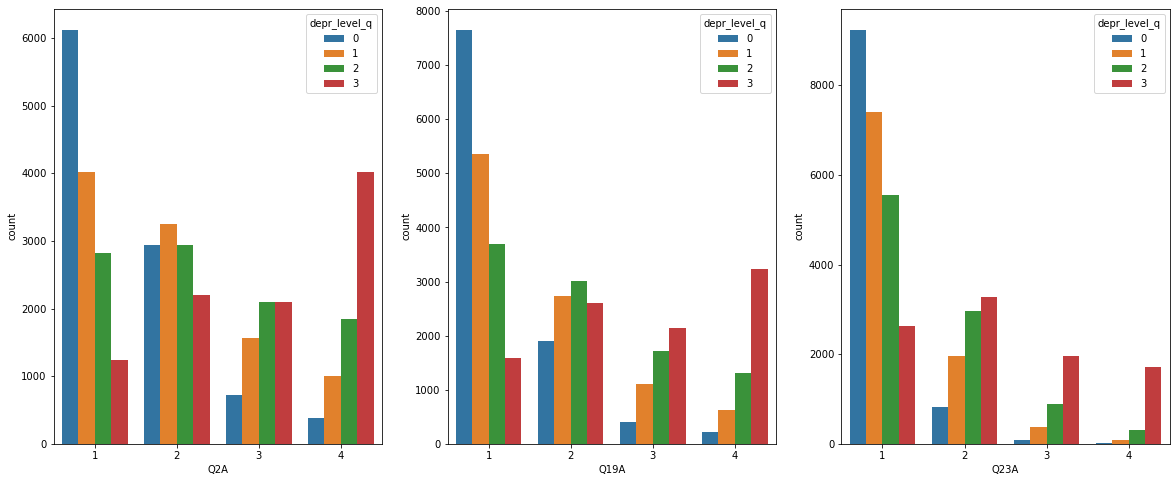

In [175]:
fig, ax=plt.subplots(1,3, figsize=(20,8))
i=0
for name in scale_q_bad.columns[:-1]:
    sns.countplot(x=scale_q_bad[name], hue=scale_q_bad['depr_level_q'], ax=ax[i])
    i+=1


Q2	I was aware of dryness of my mouth

Q19	I perspired noticeably (eg, hands sweaty) in the absence of high temperatures or physical exertion.

Q23	I had difficulty in swallowing.

Люди с высоким уровнем депрессии примерно с одинаковой частотой выбирают все варианты ответа (особенно на вопрос 23, где чаще всего выбирают вариант 2)

Люди с плохо выраженной депрессией почти не выбирают 4 вариант ответа (что в целом ожидаемо)

В целом вопросы касаются физических проявлений заболевания, для которых могут быть разные причины помимо психических (или как проявление тревоги или повышенного стресса, которые могут быть у людей и с, и без депрессии)

In [221]:
file1['age']=pd.cut(file1['age'], 10)

In [228]:
file1['age'].unique()[0]

Interval(12.896, 23.4, closed='right')

In [229]:
#объединить таблицы и тогда всё будет ок
for x in file1['age'].unique():
    fig=plt.figure(figsize=(10,5))
    sns.countplot(x=file1[file1['age']==x]['age'], hue=scales_q_answers['depr_level_q'])

ValueError: Length of grouper (26318) and axis (39272) must be same length

<Figure size 720x360 with 0 Axes>

__________

!!!

посмотреть зависимости депрессивности от пола, возраста, образования, религии, ориентации, семейных параметров

Посчитать результаты по шкале Т

Исправить тех инфу (размер экрана и локация оказались в персональной инфе)

In [29]:
scales_q_time=scale_q_data[['Q'+str(i)+'E' for i in range(1,43)]]
scales_q_time=pd.concat([scales_q_time, scales_q_answers['depr_level_q']], axis=1)
scales_q_time.head()

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q34E,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E,depr_level_q
3,5081,6837,5521,4556,3269,3231,7138,3079,9650,4179,...,5620,16760,6427,3760,4112,2769,4432,3643,3698,1
4,3215,7731,4156,2802,5628,6522,2374,3054,2975,3524,...,2536,3725,2130,3952,10694,3231,3604,1950,6265,3
6,4325,4009,3604,4826,2842,2342,9018,3717,7023,3312,...,7122,8044,2242,3951,2272,3398,5101,93656,84607,2
7,4796,2618,5823,6596,7635,7384,11570,2958,12300,3605,...,1405,10145,3675,5432,2897,2732,9251,2954,8665,0
8,3470,2139,11043,1829,5847,3529,1855,3000,6066,2539,...,1567,8033,2036,3868,3682,2751,7497,2179,3662,3


In [30]:
res=scales_q_time.mean(axis=1)
res.name='mean_time'
scales_q_time=pd.concat([scales_q_time, res], axis=1)
scales_q_time.head()

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E,depr_level_q,mean_time
3,5081,6837,5521,4556,3269,3231,7138,3079,9650,4179,...,16760,6427,3760,4112,2769,4432,3643,3698,1,5.896093e+03
4,3215,7731,4156,2802,5628,6522,2374,3054,2975,3524,...,3725,2130,3952,10694,3231,3604,1950,6265,3,3.800116e+03
6,4325,4009,3604,4826,2842,2342,9018,3717,7023,3312,...,8044,2242,3951,2272,3398,5101,93656,84607,2,1.057165e+06
7,4796,2618,5823,6596,7635,7384,11570,2958,12300,3605,...,10145,3675,5432,2897,2732,9251,2954,8665,0,5.388465e+03
8,3470,2139,11043,1829,5847,3529,1855,3000,6066,2539,...,8033,2036,3868,3682,2751,7497,2179,3662,3,4.467233e+03


<AxesSubplot:xlabel='depr_level_q', ylabel='mean_time'>

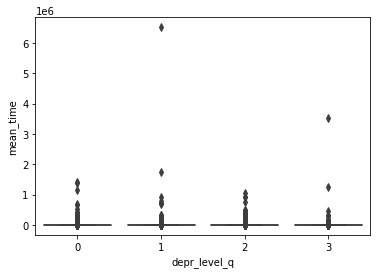

In [23]:
sns.boxplot(x='depr_level_q', y='mean_time', data=scales_q_time)

In [35]:
scales_q_time=scales_q_time.drop(list(scales_q_time[scales_q_time['mean_time']>=20000].index))

<AxesSubplot:xlabel='depr_level_q', ylabel='mean_time'>

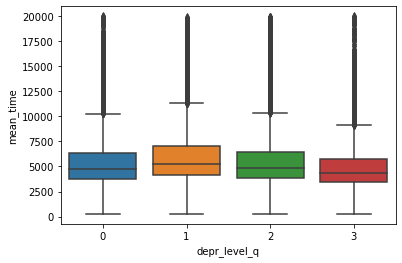

In [36]:
sns.boxplot(x='depr_level_q', y='mean_time', data=scales_q_time)

Большое количество выбросов, в среднем люди с разным уровнем депрессивности отвечают с одинаковой скоростью.

Макс время (в среднем и с учётом выбросов) показывают люди с небольшим уровнем депрессии. Возможно, они сомневаются в выборе ответа и оценке своего состояния (вроде всё не так плохо но и не так хорошо)

!!!

зависимость между тем, как одинаковые люди отвечали на разные вопросы